# Customer Purchasing Habits Exploratory Analysis (With Poisson)
Group 25: Hanson Sun, Fiona Zhong, Verness Chin

STAT 301

2025-04-06

# Introduction

In today's competitive business environment, understanding customer behavior is critical to driving marketing strategies and ensuring customer loyalty. Rust, Lemon, and Zeithaml(2004) strongly argue the superiority of a customer-centric viewpoint that maximizes customer lifetime value. As they point out, marketing returns can be precisely mapped by using customer-centric initiatives as target metrics. As companies gain access to customer data, they are turning to data-driven decision making to enhance personalization, segmentation marketing efforts, and increase customer lifetime value. Customer segmentation, especially in retail, helps organizations identify profitable customer segments and strategize accordingly.

This study seeks to explore customer purchasing behavior in the context of e-commerce and marketing campaign effectiveness using a predictive modeling approach. Specifically, we aim to investigate the following research question: **What is the association between the number of purchases a customer makes through the company’s website (NumWebPurchases) and customer demographic background, past purchasing behavior, response to marketing campaigns?** This question focuses on both **inference** and **prediction**, specifically, identifying and interpreting which demographic and behavioral factors are statistically associated with the number of purchases made online. We are not aiming to make causal claims, but rather to understand patterns of association that may inform future customer engagement strategies.

An important aspect of this analytical approach is to model customer activity in terms of count data (e.g., number of web purchases). Traditional regression models often fail to capture the discrete nature of such data. In contrast, Poisson regression models provide a robust framework for examining the impact of various factors on event counts and have been widely adopted in customer analytics for this purpose (Hilbe, 2011).

To address this question, we utilize the **Customer Personality Analysis** dataset provided by Kaggle, which contains detailed information on over 2,240 customers, providing demographic and behavioral insights into customer purchasing habits. It includes details such as age, income, marital status, and educational background, alongside purchasing behavior across different product categories (e.g., wine, meat, and sweets), tracks customer engagement through campaign responses, purchase channels (discount, store, web, catalog), and website visits. By applying Poisson regression, we aim to discover important predictors of customer purchase behavior and marketing campaign engagement, thus helping companies refine their segmentation and targeting strategies.

Below is a summary of the dataset's key variables:

| Variable Name            | Type    | Description                                                                |
|--------------------------|---------|----------------------------------------------------------------------------|
| **ID**                   | Integer | Unique identifier for each customer                                        |
| **Year_Birth**           | Integer | Year of birth of the customer                                              |
| **Education**            | Factor  | Educational qualification of the customer                                  |
| **Marital_Status**       | Factor  | Marital status of the customer                                             |
| **Income**               | Float   | Annual income of the customer                                              |
| **Kidhome**              | Integer | Number of children in the customer's household                             |
| **Teenhome**             | Integer | Number of teenagers in the customer's household                            |
| **Dt_Customer**          | Date    | Date of customer's enrollment with the company                             |
| **Recency**              | Integer | Number of days since the customer's last purchase                          |
| **Mnt`[item]`**            | Float   | Amount spent on `[item]` in the last two years (wine, fruits, meat, fish, sweets, gold)|
| **Num`[type]`**            | Integer | Number of `[type]` purchases (discount, web, catalog, store, web visits)                                |
| **AcceptedCmp1-5**       | Factor | 1 if customer accepted the offer in respective campaigns, 0 otherwise      |
| **Response**             | Factor | 1 if customer accepted the offer in the last campaign, 0 otherwise         |
| **Complain**             | Factor | 1 if customer complained in the last two years, 0 otherwise                |
| **Z_CostContact**        | Integer | Constant variable with value 3 (presumably cost related)                   |
| **Z_Revenue**            | Integer | Constant variable with value 11 (presumably revenue related)               |

**Table.1** *originally from Hanson*


### Data Citation and Information 
Unfortunately, details regarding how the data is collected is not specified, but we know it is under CC0: Public Domain.

- Dataset Owner: Akash Patel
- Kaggle link: https://www.kaggle.com/datasets/imakash3011/customer-personality-analysis
- Citation (as per Kaggle rules): Patel, Akash. Customer Personality Analysis Dataset. Kaggle. Available at: https://www.kaggle.com/datasets/imakash3011/customer-personality-analysis.


In [1]:
library(broom)
library(tidyverse)
library(ggplot2)
library(car)
library(leaps)
library(MASS)
library(dplyr)
library(repr)
library(infer)
library(cowplot)
library(GGally)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Loading required package: carData


Attaching package: ‘car’


The following object is masked from ‘package:dplyr’:

    recode


The following object is masked from ‘package:purrr’:

    some



Attaching package: ‘MASS’


The following object is masked from ‘package:dplyr’:

    select



Attaching package: ‘cowplot’


The following object is masked from ‘package:lubridate’:

    stamp


Registered S3 method overwritten by 'GGally':
  method from   
  +.gg   ggplot2



### Research Question

**How is a person's family details and purchasing habits _associated_ with the number of web purchases they make?**
- **Response Variable**: `NumWebPurchases` (count of web purchases)
- **Explanatory Variables**: `Education`, `Marital_Status`, `Income`, `Kidhome`, `Teenhome`, `MntMeatProducts`, `NumStorePurchases`, `MntSweetProducts` + everything else that isn't dropped (more details [here](#Variable-Preselection))

This question focuses on **inference**, aiming to understand how personal and family details are associated with their number of web purchases. Specifically, we want to examine the relationships between `NumWebPurchases` and the explanatory variables to determine their significance. While there could be a predictive aspect, the primary goal is to analyze these relationships rather than make future predictions.

### Variable Preselection
The following variables will be dropped:
- `ID`: user ID holds no important information.
- `Z_Revenue` and `Z_CostContact`: their meaning is not specified in the data.
- `Response`, `AcceptedCmp1-5`, `Complain`, `Dt_Customer`, `Recency`: these are related to marketing campaigns, which deviates from our problem.

## Methods and Results

### Exploratory Data Analysis (EDA)

*This section is originally from Hanson*

We will perform the following steps to help visualize and clean the data
1. remove redundant/unhelpful features
2. check for multicollinear features
3. convert the data into the correct data types
4. Merge redundant levels and drop non-sensical observations
5. visualize the data

We clean and display a section of the data below

In [2]:
# original developer: Hanson
drop_variables <- c('ID', 'Z_CostContact', 'Z_Revenue', 'Response', 'AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'Complain', 'Dt_Customer', 'Recency')
data <- read.csv(url("https://raw.githubusercontent.com/Hanson-Sun/stat301-dataset/refs/heads/main/marketing_campaign.csv"), check.names = FALSE, stringsAsFactors=TRUE, sep="\t")

# remove redundant columns
data <- data %>% dplyr::select(-all_of(drop_variables))

# convert variables into correct types
data$Education <- as.factor(data$Education)
data$Marital_Status <- as.factor(data$Marital_Status)
data$Year_Birth <- as.integer(data$Year_Birth)
data$Income <- as.numeric(data$Income)
data$Kidhome <- as.integer(data$Kidhome)
data$Teenhome <- as.integer(data$Teenhome)
spending_vars <- c("MntWines", "MntFruits", "MntMeatProducts", 
                   "MntFishProducts", "MntSweetProducts", "MntGoldProds",
                   "NumDealsPurchases", "NumWebPurchases", "NumCatalogPurchases",
                   "NumStorePurchases", "NumWebVisitsMonth")
data[spending_vars] <- lapply(data[spending_vars], as.numeric)

# print out the summary information
cat("\nUnique levels of Education:\n")
levels(data$Education)

cat("\nUnique levels of Marital Status:\n")
levels(data$Marital_Status)

cat("\nMissing data:\n")
colSums(is.na(data))

cat("\nGVIF values:\n")
full_model <- glm(NumWebPurchases ~ ., family = poisson, data = data)
round(vif(full_model)[, "GVIF"], 1)


Unique levels of Education:


[1] "2n Cycle"   "Basic"      "Graduation" "Master"     "PhD"


Unique levels of Marital Status:


[1] "Absurd"   "Alone"    "Divorced" "Married"  "Single"   "Together" "Widow"   
[8] "YOLO"


Missing data:


Year_Birth           Education      Marital_Status              Income 
                  0                   0                   0                  24 
            Kidhome            Teenhome            MntWines           MntFruits 
                  0                   0                   0                   0 
    MntMeatProducts     MntFishProducts    MntSweetProducts        MntGoldProds 
                  0                   0                   0                   0 
  NumDealsPurchases     NumWebPurchases NumCatalogPurchases   NumStorePurchases 
                  0                   0                   0                   0 
  NumWebVisitsMonth 
                  0


GVIF values:


Year_Birth           Education      Marital_Status              Income 
                1.2                 1.3                 1.1                 1.4 
            Kidhome            Teenhome            MntWines           MntFruits 
                1.8                 1.6                 2.2                 1.8 
    MntMeatProducts     MntFishProducts    MntSweetProducts        MntGoldProds 
                2.5                 2.0                 1.8                 1.4 
  NumDealsPurchases NumCatalogPurchases   NumStorePurchases   NumWebVisitsMonth 
                1.7                 2.5                 1.9                 2.1

#### Data Wrangling

There are some anomalies within our data:
- In `Marital_Status`, the levels `Absurd` and `YOLO` do not make sense, so we will drop those. Moreover, `Single` is the same as `Alone` and `Married` is the same as `Together` so they will be merged respectively. 
- In `Education`, `2n Cycle` is the European equivalent of a master's degree so it will be merged with `Master`
- 24 rows are missing `Income`; we will simply drop them instead of imputing any values.
- thankfully all our GVIF values are $\le 5$, so we do not need to drop any additional features

In [3]:
# original developer: Hanson
# clean Marital_Status column
data <- data %>%
  mutate(Marital_Status = fct_recode(Marital_Status, "Single" = "Alone", "Married" = "Together")) %>% 
  filter(!Marital_Status %in% c("Absurd", "YOLO")) %>%
  droplevels()

# clean Education column
data <- data %>%
  mutate(Education = fct_recode(Education, "Master" = "2n Cycle")) %>%
  droplevels()

# remove rows with missing data
data <- na.omit(data)


#### Data Summary

Below we have the summary statistics of the cleaned data.

In [4]:
cat("The cleaned dataset has", nrow(data), "rows and", ncol(data), "columns.\n")
head(data)

The cleaned dataset has 2212 rows and 17 columns.


,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth
,<int>,<fct>,<fct>,<dbl>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1957,Graduation,Single,58138,0,0,635,88,546,172,88,88,3,8,10,4,7
2,1954,Graduation,Single,46344,1,1,11,1,6,2,1,6,2,1,1,2,5
3,1965,Graduation,Married,71613,0,0,426,49,127,111,21,42,1,8,2,10,4
4,1984,Graduation,Married,26646,1,0,11,4,20,10,3,5,2,2,0,4,6
5,1981,PhD,Married,58293,1,0,173,43,118,46,27,15,5,5,3,6,5
6,1967,Master,Married,62513,0,1,520,42,98,0,42,14,2,6,4,10,6


**Table.2**

In [5]:
summary(data)

   Year_Birth        Education     Marital_Status     Income      
 Min.   :1893   Master    : 564   Single  : 474   Min.   :  1730  
 1st Qu.:1959   Basic     :  54   Divorced: 232   1st Qu.: 35234  
 Median :1970   Graduation:1115   Married :1430   Median : 51382  
 Mean   :1969   PhD       : 479   Widow   :  76   Mean   : 52232  
 3rd Qu.:1977                                     3rd Qu.: 68522  
 Max.   :1996                                     Max.   :666666  
    Kidhome          Teenhome         MntWines         MntFruits     
 Min.   :0.0000   Min.   :0.0000   Min.   :   0.00   Min.   :  0.00  
 1st Qu.:0.0000   1st Qu.:0.0000   1st Qu.:  23.75   1st Qu.:  1.75  
 Median :0.0000   Median :0.0000   Median : 173.50   Median :  8.00  
 Mean   :0.4426   Mean   :0.5054   Mean   : 305.03   Mean   : 26.32  
 3rd Qu.:1.0000   3rd Qu.:1.0000   3rd Qu.: 505.50   3rd Qu.: 33.00  
 Max.   :2.0000   Max.   :2.0000   Max.   :1493.00   Max.   :199.00  
 MntMeatProducts  MntFishProducts  MntSwe

#### Data Visualization

1) We will visualize a subset of the features via a **faceted violin plot**. This visualization will specifically examine the family aspect and its association with web purchases. Namely, how `Marital_Status` and family size (`Kidhome`, `Teenhome`) relate to web purchases (`NumWebPurchases`).

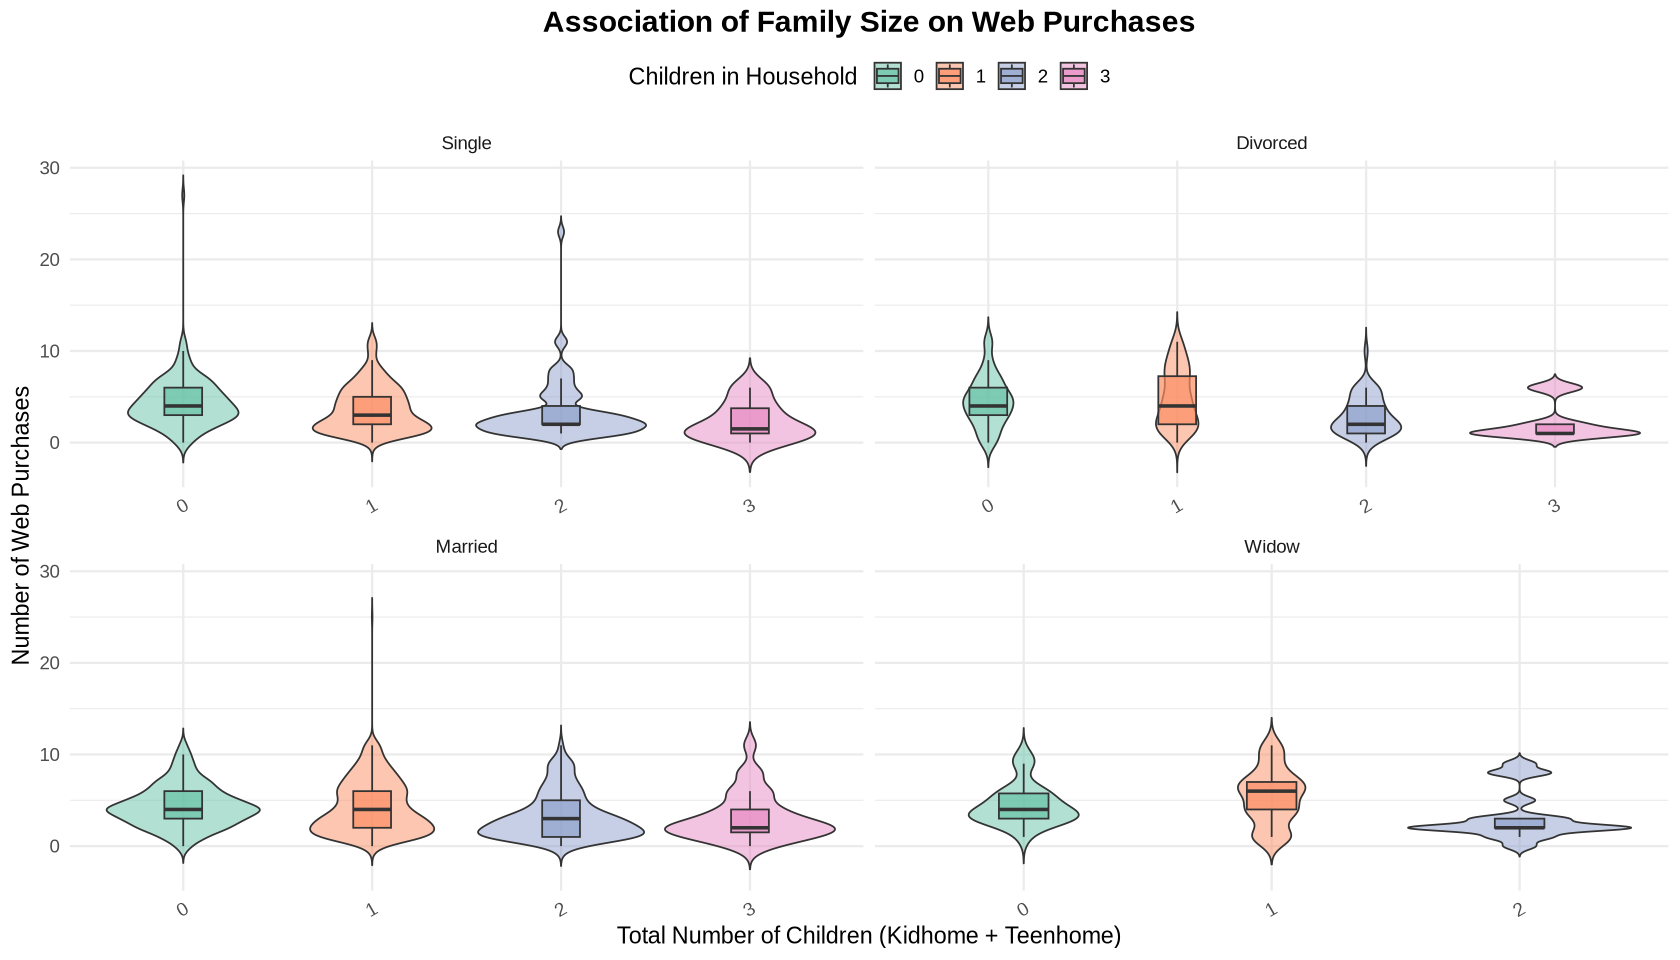

In [6]:
# original developer: Hanson
options(repr.plot.width=14, repr.plot.height=8) 

ggplot(data, aes(x = as.factor(Kidhome + Teenhome), y = NumWebPurchases, fill = as.factor(Kidhome + Teenhome))) +
  geom_violin(alpha = 0.5, trim = FALSE) + 
  geom_boxplot(width = 0.2, outlier.shape = NA, alpha = 0.7) + 
  facet_wrap(~ Marital_Status, scales = "free_x") + # add faceting
  scale_fill_brewer(palette = "Set2") + # just to look nicer
  labs(title = "Association of Family Size on Web Purchases",
       x = "Total Number of Children (Kidhome + Teenhome)",
       y = "Number of Web Purchases",
       fill = "Children in Household") +
  theme_minimal(base_size = 14) + 
  theme(
    plot.title = element_text(face = "bold", size = 18, hjust = 0.5),
    axis.text.x = element_text(angle = 30, hjust = 1), # angle the x numbers 
    legend.position = "top" 
  )

**Figure.1**

The plot shows that family size (number of children) and marital status is **associated** with web purchases. Overall, individuals with **zero** children tend to have fewer web-based purchases, while those with **one or more** children exhibit a wider spread, suggesting more variability in purchasing behavior. The effect of marital status is also apparent -- **divorced and married** individuals tend to have more web purchases than **singles or widows**, though variability exists across groups. This insight confirms that family structure is a key predictor of web purchases, and perhaps an interaction of those terms can yield helpful results.

2. Our last visualization will be a bubble plot that segments customers by education level, income, and website visits, with bubble size representing deals purchases. The goal is to uncover how these factors interact to drive web purchasing behavior.

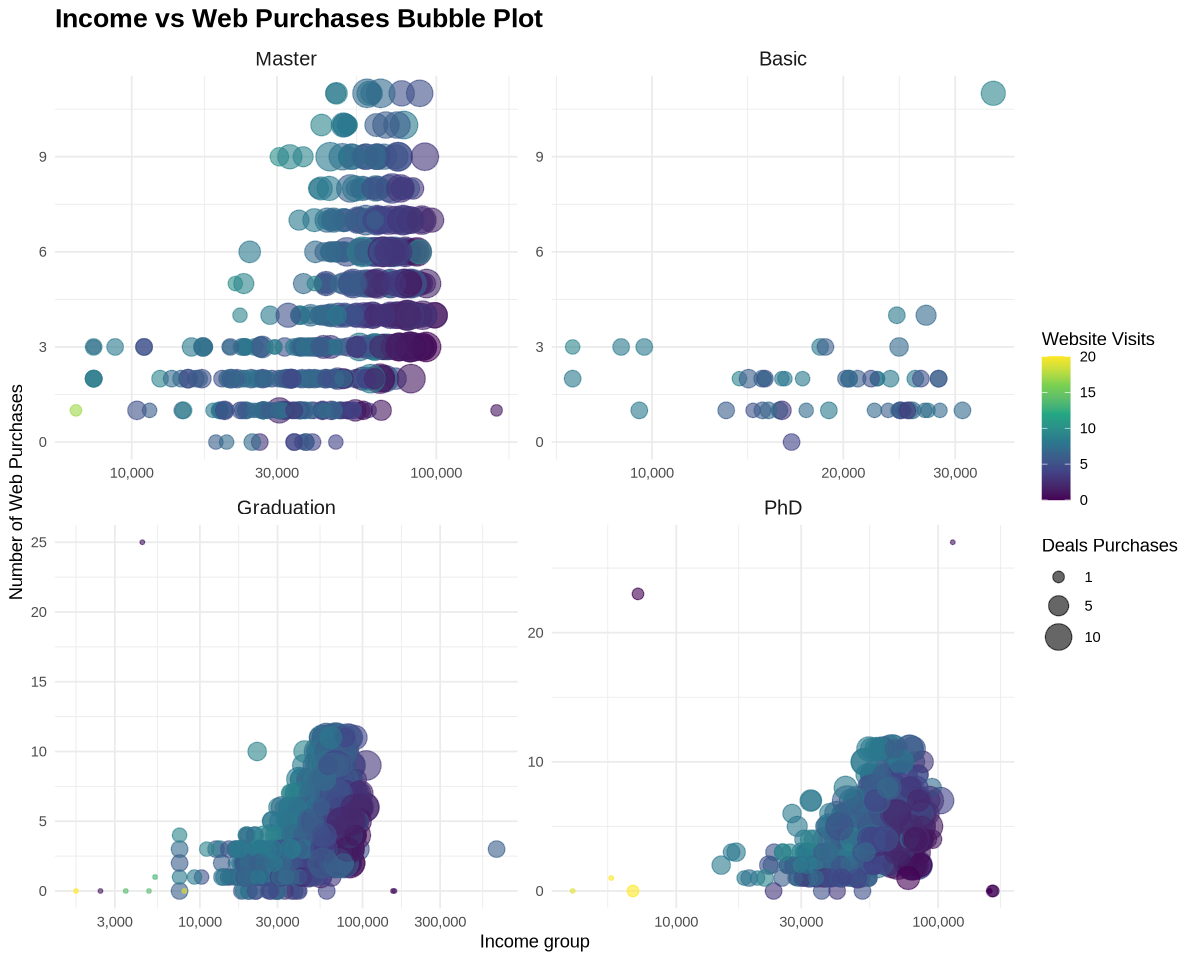

In [7]:
# original developer: Verness
options(repr.plot.width = 10, repr.plot.height = 8)
ggplot(data, aes(x = Income, y = NumWebPurchases, color = NumWebVisitsMonth, size = NumStorePurchases)) +
  geom_point(alpha = 0.6) +  
  scale_x_log10(labels = scales::comma) +  # log scale for large range of values
  scale_color_viridis_c(name = "Website Visits") +  
  scale_size_continuous(name = "Deals Purchases", breaks = c(1, 5, 10, 15), range = c(1, 8)) +  
  facet_wrap(~Education, ncol = 2, scales = "free") + # facet based on education 
  labs(
    title = "Income vs Web Purchases Bubble Plot",
    x = "Income group",
    y = "Number of Web Purchases",
    color = "Website Visits",
    size = "Deals Purchases"
  ) +
  theme_minimal() +
  theme(
    legend.position = "right",
    strip.text = element_text(size = 12),  
    plot.title = element_text(size = 16, face = "bold") 
  )

**Figure.2**

Across all four education categories (Master, Basic, Graduation, PhD), there is a general pattern where higher income groups tend to make more web purchases. The color scale for Website Visits indicates that customers with more visits (the darker/higher values) typically have a higher number of web purchases, suggesting a positive relationship between online engagement and purchasing. Meanwhile, the bubble size (Deals Purchases) varies, implying that some customers who frequently take advantage of deals also have higher web purchase counts, although this pattern is less uniform.

### Methods: Plan

*this section is originally from Hanson but heavily modifed*

The objective of this analysis is to perform inference to understand the relationships between customer characteristics and the response variable, `NumWebPurchases`. Given that the response variable represents count data, we adopt a Poisson regression model as our method of analysis. Poisson regression is specifically designed for modeling non-negative count-based outcomes, making it the most suitable method for this analysis.

We will focus on **inference** and the overview of the method is as follows:
1. Split data into selection set and inference set
2. Pick a Poisson model
3. Perform step-wise forward selection (using BIC) on the selection set
4. Train inference model and perform inference with `anova` and `z-test` ($\alpha = 0.05$)
5. Utilize inference on our best model to determine the statistical significance of our predictors.

#### Which assumptions are required, if any, to apply the method selected?
- Variance of the response is equal to the mean
- The response variable is approximately linear
- Observations are independent and identically distributed
- The true model is a subset of our available features (BIC assumption)

#### What are the potential limitations or weaknesses of the method selected?
- The variance of the response may not be equal to the mean, since the variance is often more significant than the mean (overdispersion), leading to underestimated standard errors and incorrect p-values, which would affect the effectiveness of the Poisson model
- Poisson regression may overestimate the expected counts if there are too many zero values in the response variable.
- Poisson regression only works with non-negative counts.
- Step-wise selection is based on a heuristic that may not lead to the optimal model.
- `anova` may suffer from inflated type-I error if there are too many predictors.
- The resulting predictors could be multicollinear, which will inflate $p$-values.


#### 1. Data Splitting

To avoid the post-selection inference problem and improve the generalizability of our model, we will divide the dataset into a training set (60%) and a testing set (40%), ensuring that variable selection and inference are not performed on the same data. This method would reduces the risk of overfitting.

In [8]:
set.seed(111);
selection_data <- data %>% sample_frac(0.6)
inference_data <- data %>% setdiff(selection_data)

cat("selection set has ", nrow(selection_data), "rows and inference set has ", nrow(inference_data), "rows\n")

selection set has  1327 rows and inference set has  752 rows


#### 2. Model Selection for Poisson Regression

`full_model` fits a Poisson regression model using all available predictors in the selection_data dataset to explain the response variable NumWebPurchases. And `null_model` fits a null model, which includes only the intercept and no predictors. This serves as a baseline model to compare against the full models

These two models represent the starting and ending points for stepwise selection algorithms. Since we are performing a forward selection, the algorithm would start from the null_model and add predictors one by one, selecting those that most improve the model based on BIC.

In [9]:
full_model <- glm(NumWebPurchases ~ ., family = poisson, data = selection_data)
null_model <- glm(NumWebPurchases ~ 1, family = poisson, data = selection_data)

#### 3. Step-wise Variable Selection
We will use `stepAIC` and the $\log$ approximation of `k` to get selection with BIC. To determine the most relevant covariates for modeling, we apply a stepwise forward selection procedure using the Bayesian Information Criterion (BIC) on the selection set. BIC is chosen over AIC because it imposes a stronger penalty for model complexity, thus favoring simpler, more interpretable models in line with the principle of parsimony. Once a final set of predictors is selected, we fit a Poisson regression model on the inference set and conduct inference using z-tests for the significance of individual coefficients and likelihood ratio tests (via ANOVA) for comparing nested models.

This approach allows us to draw valid conclusions about which customer attributes are most strongly associated with online purchasing behavior while controlling for the risk of overfitting. Inference results from the final model will be interpreted in terms of both statistical significance and practical effect sizes, offering insights into the factors that drive web-based shopping activity.

In [10]:
set.seed(100);
suppress_output <- capture.output( # keeps everything clean
  # step aic using forward selection
  selected_model <- stepAIC(null_model, 
                            scope = list(lower = null_model, upper = full_model),
                            direction = "forward", 
                            k = log(nrow(selection_data))) # BIC
)

# extracting details
m_coefficients <- names(coef(selected_model))
m_coefficients <- m_coefficients[m_coefficients != "(Intercept)"]
cat("Deviance of the model:", selected_model$deviance, "Degrees of freedom:", selected_model$df.residual,  "\n")
vif(selected_model)

Deviance of the model: 1366.854 Degrees of freedom: 1317 


MntWines NumStorePurchases NumDealsPurchases           Kidhome 
         1.644018          1.763295          1.603919          1.574292 
     MntGoldProds NumWebVisitsMonth            Income  MntSweetProducts 
         1.258814          1.666512          1.266883          1.388048 
         Teenhome 
         1.308276

After step-wise selection: 
- the VIF values are all less than 2, so multicollinearity is not a big problem with our predictors.
- Moreover, the deviance is close to the degrees of freedom, so we do not observe a significant amount of over-dispersion.

In [11]:
var_importance <- coef(selected_model) %>%
  enframe(name = "Term", value = "Estimate") 

# importance is the magnitude of the coefficient
var_importance <- var_importance %>%
  filter(Term != "(Intercept)") %>%
  mutate(Estimate = abs(Estimate)) %>%
  arrange(desc(Estimate))
coef(selected_model)

(Intercept)          MntWines NumStorePurchases NumDealsPurchases 
     3.789446e-01      4.410077e-04      3.709222e-02      4.035515e-02 
          Kidhome      MntGoldProds NumWebVisitsMonth            Income 
    -2.533286e-01      1.692651e-03      5.306298e-02      2.516848e-06 
 MntSweetProducts          Teenhome 
     1.843160e-03      1.078881e-01

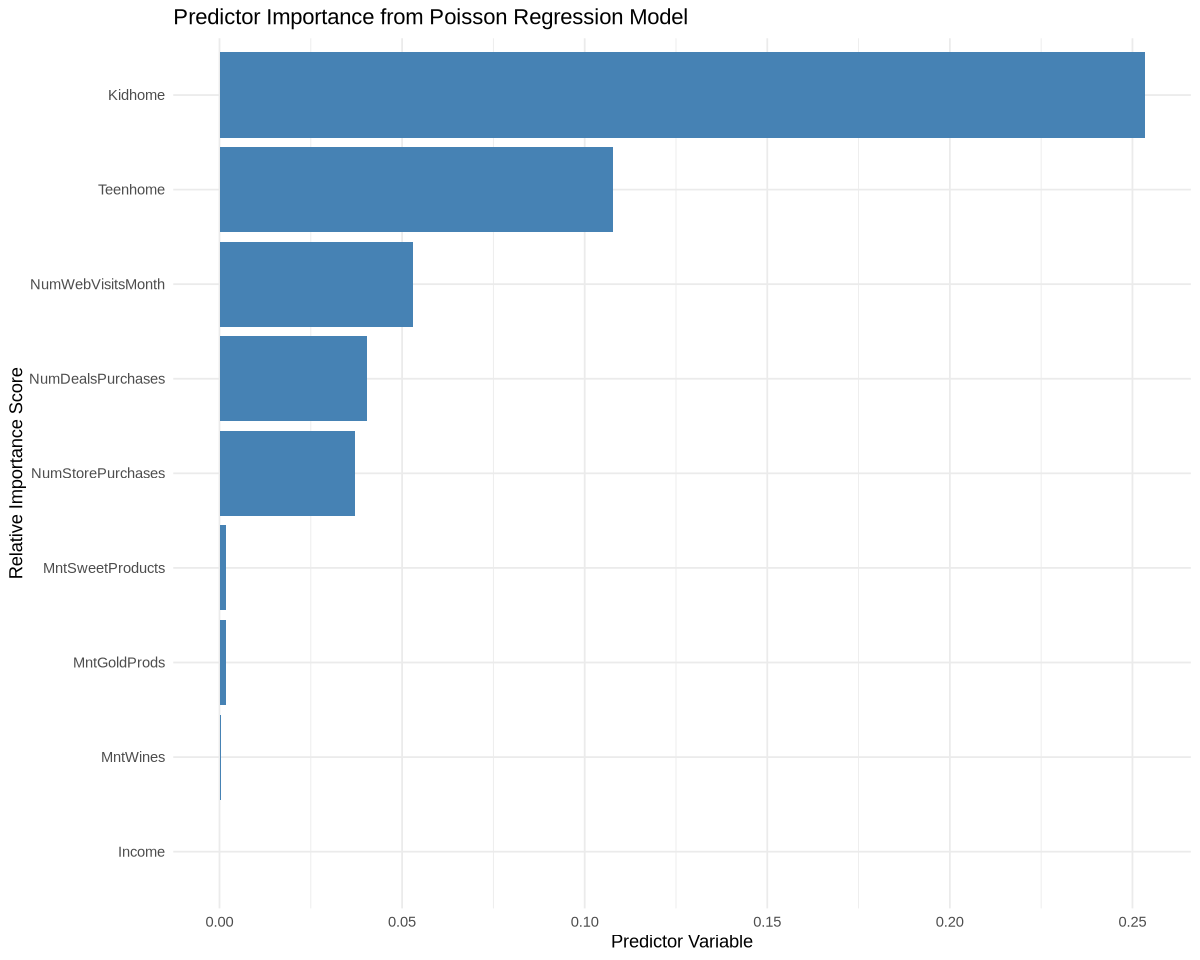

In [12]:
# plot of feature importance
ggplot(var_importance, aes(x = reorder(Term, Estimate), y = Estimate)) + 
  geom_col(fill = "steelblue") +
  coord_flip() + 
  labs(
    title = "Predictor Importance from Poisson Regression Model",
    y = "Predictor Variable",
    x = "Relative Importance Score" 
  ) +
  theme_minimal()

**Figure.3**

From the training set, our variable importance analysis from the stepwise Poisson regression model reveals that `KidHome` and `Teenhome` stand out as the strongest predictors, indicating that the number of children at home is highly associated with the number of web purchases. Other key contributors include `NumStorePurchases`, `NumWebVisitsMonth`, and `NumDealsPurchases`, suggesting that promotional engagement and alternative purchase channels significantly relate to web purchase behavior. Other purchasing indicators like `MntGoldProds`, `MntSweetProducts`, `MntWines` provide additional context but contribute less overall.

#### 4. Inference and Final Results

To assess the significance of the full Poisson model, a likelihood ratio test, ANOVA with `test = "Chisq"`, was conducted comparing the final model to a null model. The final inference will use the **selection set** to prevent double dipping.

In [13]:
# original developer: Hanson
set.seed(1000);
# final model on inference set
inference_model <- glm(
  formula = as.formula(paste("NumWebPurchases ~", paste(m_coefficients, collapse = " + "))),
  family = poisson,
  data = inference_data
)
# null model for comparison
inference_null_model <- glm(NumWebPurchases ~ 1, family = poisson, data = inference_data)
anova_res <- anova(inference_null_model, inference_model, test = "Chisq")
coef_res <- coef(summary(inference_model))

# join anova and coef results in one DF
anova_df <- as.data.frame(anova_res) %>% mutate(Type = "ANOVA")
coef_df <- as.data.frame(coef_res) %>% mutate(Type = "Coefficients", Term = rownames(.))
combined_results <- bind_rows(anova_df, coef_df, .id = "Source")
combined_results


,Source,Resid. Df,Resid. Dev,Df,Deviance,Pr(>Chi),Type,Estimate,Std. Error,z value,Pr(>|z|),Term
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1,1,751,1340.5424,NA,NA,NA,ANOVA,NA,NA,NA,NA,NA
2,1,742,577.9206,9,762.6218,2.35288e-158,ANOVA,NA,NA,NA,NA,NA
(Intercept),2,NA,NA,NA,NA,NA,Coefficients,-0.4046982349,1.220809e-01,-3.3150012,9.164273e-04,(Intercept)
MntWines,2,NA,NA,NA,NA,NA,Coefficients,0.0002556226,7.220747e-05,3.5401129,3.999560e-04,MntWines
NumStorePurchases,2,NA,NA,NA,NA,NA,Coefficients,0.0486537564,7.395617e-03,6.5787289,4.744870e-11,NumStorePurchases
NumDealsPurchases,2,NA,NA,NA,NA,NA,Coefficients,0.0575491829,9.311330e-03,6.1805544,6.387690e-10,NumDealsPurchases
Kidhome,2,NA,NA,NA,NA,NA,Coefficients,-0.2218539984,5.001215e-02,-4.4360024,9.164481e-06,Kidhome
MntGoldProds,2,NA,NA,NA,NA,NA,Coefficients,0.0015493853,3.573011e-04,4.3363574,1.448634e-05,MntGoldProds
NumWebVisitsMonth,2,NA,NA,NA,NA,NA,Coefficients,0.1207246645,1.146670e-02,10.5282806,6.399264e-26,NumWebVisitsMonth


**Table.3**

#### 5. Coefficient Interpretation and Significance
The Poisson regression model significantly outperformed the null model ($\chi^2(10)=762.6$, $p<2.35\times 10^{-158	}$), effectively explaining variations in customer web purchases. At a $5\%$ significance level, all predictors except for `Teenhome` are significantly *associated* with the number of web purchases.

In more detail, the final Poisson regression model retained nine predictors: `MntWines`, `NumDealsPurchases`, `Kidhome`, `Teenhome`, `MntGoldProds`, `MntSweetProducts`, `NumWebVisitsMonth`, `Income`, `NumStorePurchases`. Interestingly, all of the selected variables are numerical.

We can interpret our variables as follows (using Kidhome as an example)
- An increase of one child in a household (`Kidhome`) is associated with the expected number of web purchases being multiplied by $e^{-0.221} \approx 0.801$. This means a decrease of about $19.8\%$ in the expected number of web purchases for each additional child, holding other variables constant
- A one-unit change in `<variable>` is associated with the expected number of web purchases being multiplied by `exp(<estimate>)`, representing a `(exp(<estimate>) - 1) * 100%` change.


Spending-related variables (such as `MntWines`, `MntGoldProds`, and `MntSweetProducts`) and behavioral indicators (`NumDealsPurchases` and `NumWebVisitsMonth`) show strong positive associations, while `Kidhome` is the only variable negatively associated with web purchases. This may suggest reduced online engagement in households with younger dependents and customer preference for one non-store channel over the other. The positive effect of `NumStorePurchases` implies that those who purchase frequently in-store are also active online shoppers, suggesting multi-channel engagement rather than substitution. These results suggest that behavioral patterns and product preferences are stronger predictors of online purchasing activity than demographic variables like age. This confirms that the selected set of predictors contributes meaningfully to explaining the variation in web purchases.



## Discussion
This project aimed to understand the factors associated with the number of web purchases (`NumWebPurchases`) customers make, focusing on inference using Poisson regression. By employing a split-sample approach for variable selection and inference, we identified several significant predictors of online purchasing frequency.

#### Summary of Findings and Implications:
Our final Poisson model significantly outperformed the null model, indicating its effectiveness in explaining variations in web purchases. Key significant findings (at $\alpha = 0.05$) revealed that higher web purchase frequency is positively associated with:
- More monthly web visits
- Higher annual Income
- More purchases using deals
- Increased spending on specific product categories: `MntWines`, `MntGoldProds`, and `MntSweetProducts`.
- A higher number of store purchases
- Conversely, having more young children (`Kidhome`) was strongly associated with a lower frequency of web purchases
- Notably, the number of teenagers (`Teenhome`) was not found to be significantly associated with web purchase frequency in this model.

The implications of these findings are multi-faceted. Businesses should prioritize strategies to increase website traffic (`NumWebVisitsMonth`) and enhance online engagement. The significance of `Income` underscores the role of purchasing power, while the significance of multiple spending categories (`MntWines`, `MntGoldProds`, `MntSweetProducts`) suggests that customers purchasing these items are also more frequent web shoppers, potentially representing higher-value segments for online targeting. The positive link between `NumStorePurchases` and `NumWebPurchases` strongly supports an omnichannel view, indicating active store shoppers often complement their activity online. The negative impact of `Kidhome` identifies households with young children as a distinct segment potentially requiring tailored outreach or facing constraints affecting their online shopping frequency.

#### Expected vs. Actual Results:
Most results aligned with general expectations: higher income, web visits, deal usage, and spending on discretionary items correlating with more web purchases. The positive association between store and web purchases (`NumStorePurchases`), aligns with modern omnichannel retail theory where engaged customers utilize multiple touchpoints. The significance of `MntGoldProds` and `MntSweetProducts` (in addition to `MntWines`) fits the expectation that higher spending across various categories often correlates with purchase frequency. The continued lack of significance for `Teenhome`, contrasting with the strong effect of `Kidhome`, remains noteworthy, suggesting the influence of children on parental web shopping frequency might diminish significantly as they age or is captured by other included variables.


#### Model Limitations and Potential Improvements:
Firstly, the residual deviance ($577.92$) is lower than the residual degrees of freedom ($762.62$), suggesting potential underdispersion. While less common than overdispersion, it can affect standard error interpretation; diagnostic checks are recommended (this may require a rework of the method since AIC is not supported for quasi-poisson). Secondly, the model assumes linear relationships (on the log scale) and includes no interaction terms. Exploring non-linear effects (e.g., for `Income` or `NumWebVisitsMonth`) using techniques like testing specific interactions (e.g., `Income * Kidhome`) could yield a better fit or uncover more nuanced relationships. Finally, while BIC-driven forward selection offers parsimony, alternative variable selection methods or criteria might lead to slightly different models.

#### Future Research Directions:
Future research could model the monetary value of web purchases rather than just the count. As understanding consumer channel preferences is vital for comprehending cross-channel behavior (Chatterjee, 2010), analyzing channel choice directly (e.g., web vs. store vs. catalog) using multinomial models could provide a better understanding of cross-channel behavior. On the other hand, Kashwan and Velu (2013) have discussed how mathematical models can identify groups of similar customers, facilitating personalized marketing strategies, and as such, we can leveraging the significant predictors for customer segmentation via clustering could enable more precise marketing targeting. Finally, further exploring the distinct impacts of `Kidhome` versus `Teenhome` could involve interaction analyses or qualitative research.

#### Conclusion
In conclusion, this inferential analysis successfully identified key behavioral, financial, and demographic factors associated with web purchase frequency. The findings emphasize the importance of online engagement, omnichannel behavior, income, specific product spending patterns, and family structure (specifically young children) in driving customer activity, providing valuable direction for targeted marketing and customer engagement strategies.




## References

Chatterjee, P. (2010), "Multiple‐channel and cross‐channel shopping behavior: role of consumer shopping orientations", *Marketing Intelligence & Planning*, Vol. 28 No. 1, pp. 9-24. https://doi.org/10.1108/02634501011014589

Hilbe, J. M. (2011). Poisson regression. In *Negative Binomial Regression* (pp. 77–140). chapter, Cambridge: Cambridge University Press.

Kashwan, K. R., & Velu, C. M. (2013). Customer segmentation using clustering and data mining techniques. *International Journal of Computer Theory and Engineering*, 5(6), 856.

Rust, R. T., Lemon, K. N., & Zeithaml, V. A. (2004). Return on Marketing: Using Customer Equity to Focus Marketing Strategy. *Journal of Marketing, 68*(1), 109-127. https://doi.org/10.1509/jmkg.68.1.109.24030 (Original work published 2004)
